# DRSM Final Project - 213889

## Introduction 

The data I have was taken from 9 subjects completing 24 activities, which is split up into 9 main data frames (1 for each subject) and 5 optional data frames (for subjects 1,5,6,8,9) which include some extra exercises. The data was collected from the subjects during the activities using 4 monitors:
- 3 inertial measurement units (these include an accelerometer, gyroscope, and a magnetometer to collect data on the subjects acceleration, angle, and orientation) which were placed on the ankle, chest, and wrist. 
- A heart rate monitor. 

The modules I require for this analysis: 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import math
import warnings
warnings.filterwarnings('ignore')
from sklearn import cluster
from sklearn.metrics.cluster import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

## Importing and Cleaning the Data

Before I can start my analysis of the data, I need to import my data and clean it. I will start by importing the data frames into this jupyter notebook. 

In [2]:
# add all 9 data sets into a list
list_of_data = []
for i in range(1,10):
    a = pd.read_csv('subject10{}.csv'.format(i))
    list_of_data.append(a)
    
# Create a variable name for each subject 

sub1 = list_of_data[0]
sub2 = list_of_data[1]
sub3 = list_of_data[2]
sub4 = list_of_data[3]
sub5 = list_of_data[4]
sub6 = list_of_data[5]
sub7 = list_of_data[6]
sub8 = list_of_data[7]
sub9 = list_of_data[8]

# Now the same for the optional data sets 

list_of_data_2 = []
subjects_opt = [1,5,6,8,9]
for i in subjects_opt:
    a = pd.read_csv('optsubject10{}.csv'.format(i))
    list_of_data_2.append(a)
    
# assigning the optional data to the correct variable names

optsub1 = list_of_data_2[0]
optsub5 = list_of_data_2[1]
optsub6 = list_of_data_2[2]
optsub8 = list_of_data_2[3]
optsub9 = list_of_data_2[4]

As the data currently has no column headers, I will create these and add them to each data frame. 

In [3]:
# Create the appropriate column names for every data set (all have the same layout)

columns = ["timestamp", "activityid", "heart_rate", "hand_temp", "hand16_1", "hand16_2", "hand16_3", "hand6_1", "hand6_2", "hand6_3", "handgyro1", "handgyro2", "handgyro3", "handmagnet1", "handmagnet2", "handmagnet3", "handorientation1", "handorientation2", "handorientation3", "handorientation4", "chest_temp", "chest16_1", "chest16_2", "chest16_3", "chest6_1", "chest6_2", "chest6_3", "chestgyro1", "chestgyro2", "chestgyro3", "chestmagnet1", "chestmagnet2", "chestmagnet3", "chestorientation1", "chestorientation2", "chestorientation3", "chestorientation4", "ankle_temp", "ankle16_1", "ankle16_2", "ankle16_3", "ankle6_1", "ankle6_2", "ankle6_3", "anklegyro1", "anklegyro2", "anklegyro3", "anklemagnet1", "anklemagnet2", "anklemagnet3", "ankleorientation1", "ankleorientation2", "ankleorientation3", "ankleorientation4"]

# append the column names to the data frames

for i in range(1,10):
    eval("sub"+str(i)).columns = columns
    
for i in subjects_opt:
    eval("optsub"+str(i)).columns = columns

Each activity has a corresponding number in the data, for which '0' corresponds to the time inbetween the activities, thus this data is useless to us. I will now remove this. 

In [4]:
# removing activity 0 from all data sets as this is useless data

sub1 = sub1[sub1.activityid != 0]
sub2 = sub2[sub2.activityid != 0]
sub3 = sub3[sub3.activityid != 0]
sub4 = sub4[sub4.activityid != 0]
sub5 = sub5[sub5.activityid != 0]
sub6 = sub6[sub6.activityid != 0]
sub7 = sub7[sub7.activityid != 0]
sub8 = sub8[sub8.activityid != 0]
sub9 = sub9[sub9.activityid != 0]
optsub1 = optsub1[optsub1.activityid != 0]
optsub5 = optsub5[optsub5.activityid != 0]
optsub6 = optsub6[optsub6.activityid != 0]
optsub8 = optsub8[optsub8.activityid != 0]
optsub9 = optsub9[optsub9.activityid != 0]

There are currently many values that are stings of '#NUM!' which were created in excel. This needs to be changed to np.nan so they do not affect any computations I will make. Also I will convert all values to floats so there is no issues with differing types.

In [5]:
sub1 = sub1.replace('#NUM!', np.nan) 
sub1 = sub1.astype(float)

sub2 = sub2.replace('#NUM!', np.nan) 
sub2 = sub2.astype(float)

sub3 = sub3.replace('#NUM!', np.nan) 
sub3 = sub3.astype(float)

sub4 = sub4.replace('#NUM!', np.nan) 
sub4 = sub4.astype(float)

sub5 = sub5.replace('#NUM!', np.nan) 
sub5 = sub5.astype(float)

sub6 = sub6.replace('#NUM!', np.nan) 
sub6 = sub6.astype(float)

sub7 = sub7.replace('#NUM!', np.nan) 
sub7 = sub7.astype(float)

sub8 = sub8.replace('#NUM!', np.nan) 
sub8 = sub8.astype(float)

sub9 = sub9.replace('#NUM!', np.nan) 
sub9 = sub9.astype(float)
    
optsub1 = optsub1.replace('#NUM!', np.nan)
optsub1 = optsub1.astype(float)

optsub5 = optsub5.replace('#NUM!', np.nan)
optsub5 = optsub5.astype(float)

optsub6 = optsub6.replace('#NUM!', np.nan)
optsub6 = optsub6.astype(float)

optsub8 = optsub8.replace('#NUM!', np.nan)
optsub8 = optsub8.astype(float)

optsub9 = optsub9.replace('#NUM!', np.nan)
optsub9 = optsub9.astype(float)

As the timestamps on the optional data frames do not match up with the originals, I will make a function to correct this. 

In [6]:
# As the optional timestamps do not match up with the original sets, make a function to correct this 
def correct_times(prot, opt):
    start = prot.iloc[-1,0] + 0.01
    opt.timestamp = opt.timestamp + start - opt.iloc[0,0]

# loop over the optionals to correct there times 
for i in subjects_opt:
    correct_times(eval("sub"+str(i)), eval("optsub"+str(i)))

Lastly, there are some columns that are inaccurate data from some of the IMUs, so I will remove this data from every data frame.

In [7]:
# On the explanation of these data sets, they recommend to only use the data from the first accelerometer 
# (with the scale of ±16g) so I will remove the columns with the second accelerometer data

def remove_data(df):
    df = df.drop(["hand6_1", "hand6_2", "hand6_3", "chest6_1", "chest6_2", "chest6_3", "ankle6_1", "ankle6_2", "ankle6_3", "ankleorientation1", "ankleorientation2", "ankleorientation3", "chestorientation1", "chestorientation2", "chestorientation3", "handorientation1", "handorientation2", "handorientation3"], axis = 1, inplace = True)
    return df

for i in range (1,10):
    remove_data(eval('sub'+str(i)))
    
for i in subjects_opt:
    remove_data(eval('optsub'+str(i)))

Now the data is cleaned, I can concatenate the optional data with the original data to have 9 complete data frames of the 9 subjects. 

In [8]:
sub1 = pd.concat([sub1, optsub1])
sub5 = pd.concat([sub5, optsub5])
sub6 = pd.concat([sub6, optsub6])
sub8 = pd.concat([sub8, optsub8])
sub9 = pd.concat([sub9, optsub9])

## Heart rate 

To start my data analysis, I will explore heart rate as an indicator of type and level of activity. It is obvious that heart rate will give us information about a subjects activity, but we are currently unsure exactly how accurate and reliable it is as an indicator. Firstly I will plot graphs that will show us the range of heart rate for each subject in each activity, to see how heart rate differs between activities. 

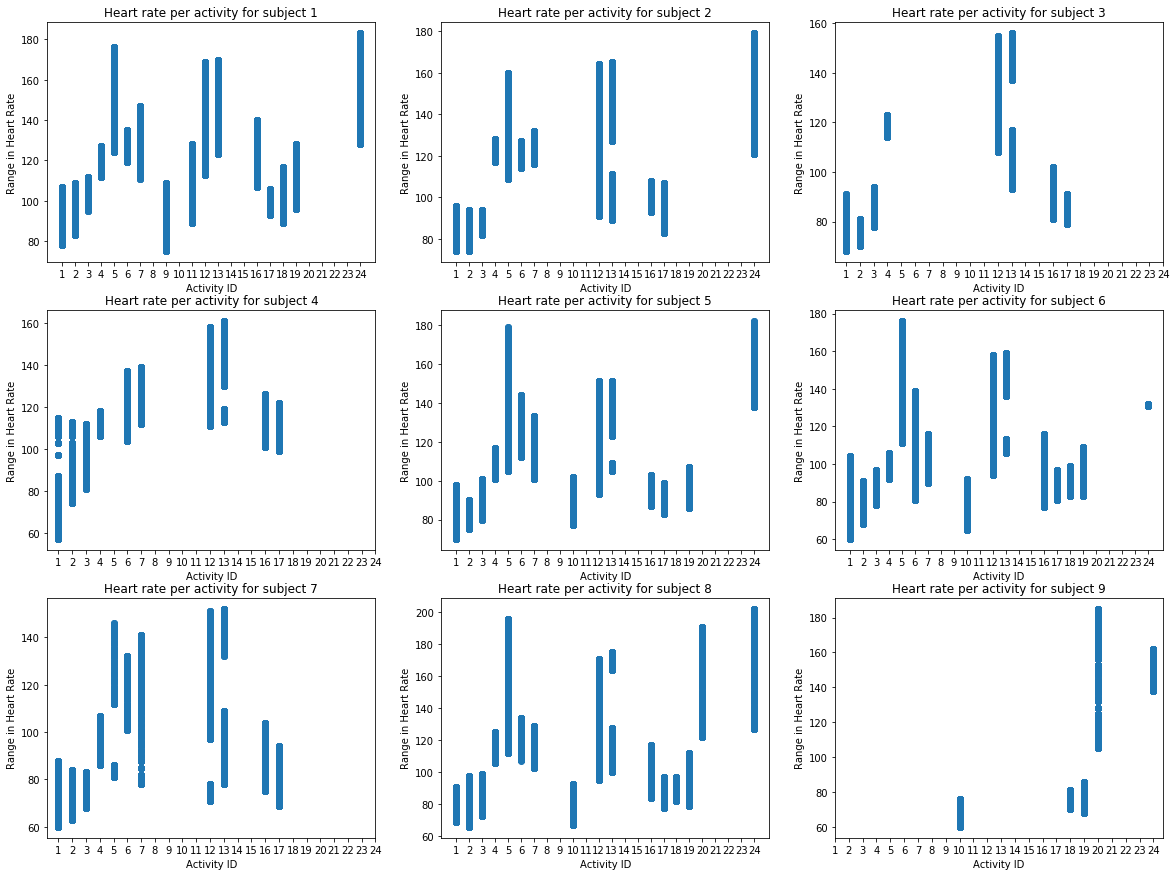

In [9]:
# PLotting heart rate for every activity for all subjects

fig = plt.figure(figsize=(20,15))
for i in range(1,10):
    exec(f'ax{i} = fig.add_subplot(3, 3, {i})')
    eval('ax'+str(i)).scatter(eval('sub'+str(i)).activityid, eval('sub'+str(i)).heart_rate)
    eval('ax'+str(i)).set_title('Heart rate per activity for subject '+str(i))
    eval('ax'+str(i)).set_xticks(range(1,25))
    eval('ax'+str(i)).set_ylabel('Range in Heart Rate')
    eval('ax'+str(i)).set_xlabel('Activity ID')

Looking at these graphs, we can see that some activities have very large differences in the range of their heart rate. For example, walking (4), running (5), and sitting (2) heart rates all look significantly different. This suggests we may be able to use heart rate recordings to tell what activity they are currently doing. This would be an extremely useful quality of a fitness device. Below I will plot some graphs of the 3 activities I mentioned earlier, to see if the heart rate scores follow a trend for all the subjects that partook in the activities. 

I will start with plotting each subjects heart rate over time while running.

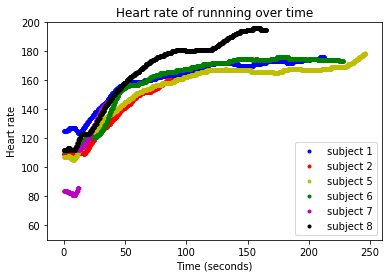

In [10]:
# Heart rate for all subjects on activity 5 (running)

sub1_activity5_hr = sub1[sub1.activityid==5].heart_rate
sub1_activity5_ts = sub1[sub1.activityid==5].timestamp
sub1_activity5_ts = sub1_activity5_ts - sub1_activity5_ts.iloc[0]

sub2_activity5_hr = sub2[sub2.activityid==5].heart_rate
sub2_activity5_ts = sub2[sub2.activityid==5].timestamp
sub2_activity5_ts = sub2_activity5_ts - sub2_activity5_ts.iloc[0]

sub5_activity5_hr = sub5[sub5.activityid==5].heart_rate
sub5_activity5_ts = sub5[sub5.activityid==5].timestamp
sub5_activity5_ts = sub5_activity5_ts - sub5_activity5_ts.iloc[0]

sub6_activity5_hr = sub6[sub6.activityid==5].heart_rate
sub6_activity5_ts = sub6[sub6.activityid==5].timestamp
sub6_activity5_ts = sub6_activity5_ts - sub6_activity5_ts.iloc[0]

sub7_activity5_hr = sub7[sub7.activityid==5].heart_rate
sub7_activity5_ts = sub7[sub7.activityid==5].timestamp
sub7_activity5_ts = sub7_activity5_ts - sub7_activity5_ts.iloc[0]

sub8_activity5_hr = sub8[sub8.activityid==5].heart_rate
sub8_activity5_ts = sub8[sub8.activityid==5].timestamp
sub8_activity5_ts = sub8_activity5_ts - sub8_activity5_ts.iloc[0]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(sub1_activity5_ts, sub1_activity5_hr, c='b', marker=".", label='subject 1')
ax1.scatter(sub2_activity5_ts, sub2_activity5_hr, c='r', marker=".", label='subject 2')
ax1.scatter(sub5_activity5_ts, sub5_activity5_hr, c='y', marker=".", label='subject 5')
ax1.scatter(sub6_activity5_ts, sub6_activity5_hr, c='g', marker=".", label='subject 6')
ax1.scatter(sub7_activity5_ts, sub7_activity5_hr, c='m', marker=".", label='subject 7')
ax1.scatter(sub8_activity5_ts, sub8_activity5_hr, c='k', marker=".", label='subject 8')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylabel('Heart rate')
ax1.set_ylim(50,200)
ax1.set_title('Heart rate of runnning over time')
plt.legend(loc='lower right')

Now I will plot heart rate over time for walking.

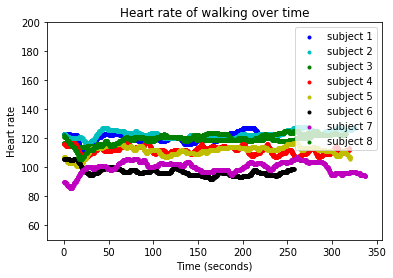

In [11]:
# Heart rate for all subjects on activity 4 (walking)

sub1_activity4_hr = sub1[sub1.activityid==4].heart_rate
sub1_activity4_ts = sub1[sub1.activityid==4].timestamp
sub1_activity4_ts = sub1_activity4_ts - sub1_activity4_ts.iloc[0]

sub2_activity4_hr = sub2[sub2.activityid==4].heart_rate
sub2_activity4_ts = sub2[sub2.activityid==4].timestamp
sub2_activity4_ts = sub2_activity4_ts - sub2_activity4_ts.iloc[0]

sub3_activity4_hr = sub3[sub3.activityid==4].heart_rate
sub3_activity4_ts = sub3[sub3.activityid==4].timestamp
sub3_activity4_ts = sub3_activity4_ts - sub3_activity4_ts.iloc[0]

sub4_activity4_hr = sub4[sub4.activityid==4].heart_rate
sub4_activity4_ts = sub4[sub4.activityid==4].timestamp
sub4_activity4_ts = sub4_activity4_ts - sub4_activity4_ts.iloc[0]

sub5_activity4_hr = sub5[sub5.activityid==4].heart_rate
sub5_activity4_ts = sub5[sub5.activityid==4].timestamp
sub5_activity4_ts = sub5_activity4_ts - sub5_activity4_ts.iloc[0]

sub6_activity4_hr = sub6[sub6.activityid==4].heart_rate
sub6_activity4_ts = sub6[sub6.activityid==4].timestamp
sub6_activity4_ts = sub6_activity4_ts - sub6_activity4_ts.iloc[0]

sub7_activity4_hr = sub7[sub7.activityid==4].heart_rate
sub7_activity4_ts = sub7[sub7.activityid==4].timestamp
sub7_activity4_ts = sub7_activity4_ts - sub7_activity4_ts.iloc[0]

sub8_activity4_hr = sub8[sub8.activityid==4].heart_rate
sub8_activity4_ts = sub8[sub8.activityid==4].timestamp
sub8_activity4_ts = sub8_activity4_ts - sub8_activity4_ts.iloc[0]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(sub1_activity4_ts, sub1_activity4_hr, c='b', marker=".", label='subject 1')
ax1.scatter(sub2_activity4_ts, sub2_activity4_hr, c='c', marker=".", label='subject 2')
ax1.scatter(sub3_activity4_ts, sub3_activity4_hr, c='g', marker=".", label='subject 3')
ax1.scatter(sub4_activity4_ts, sub4_activity4_hr, c='r', marker=".", label='subject 4')
ax1.scatter(sub5_activity4_ts, sub5_activity4_hr, c='y', marker=".", label='subject 5')
ax1.scatter(sub6_activity4_ts, sub6_activity4_hr, c='k', marker=".", label='subject 6')
ax1.scatter(sub7_activity4_ts, sub7_activity4_hr, c='m', marker=".", label='subject 7')
ax1.scatter(sub8_activity4_ts, sub8_activity4_hr, c='g', marker=".", label='subject 8')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylim(50, 200)
ax1.set_ylabel('Heart rate')
ax1.set_title('Heart rate of walking over time')
plt.legend(loc='upper right')

Now I will plot heart rate over time for sitting. 

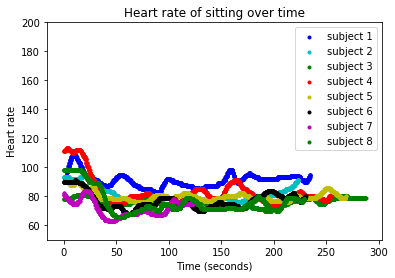

In [12]:
# Heart rate for all subjects on activity 2 (sitting)

sub1_activity2_hr = sub1[sub1.activityid==2].heart_rate
sub1_activity2_ts = sub1[sub1.activityid==2].timestamp
sub1_activity2_ts = sub1_activity2_ts - sub1_activity2_ts.iloc[0]

sub2_activity2_hr = sub2[sub2.activityid==2].heart_rate
sub2_activity2_ts = sub2[sub2.activityid==2].timestamp
sub2_activity2_ts = sub2_activity2_ts - sub2_activity2_ts.iloc[0]

sub3_activity2_hr = sub3[sub3.activityid==2].heart_rate
sub3_activity2_ts = sub3[sub3.activityid==2].timestamp
sub3_activity2_ts = sub3_activity2_ts - sub3_activity2_ts.iloc[0]

sub4_activity2_hr = sub4[sub4.activityid==2].heart_rate
sub4_activity2_ts = sub4[sub4.activityid==2].timestamp
sub4_activity2_ts = sub4_activity2_ts - sub4_activity2_ts.iloc[0]

sub5_activity2_hr = sub5[sub5.activityid==2].heart_rate
sub5_activity2_ts = sub5[sub5.activityid==2].timestamp
sub5_activity2_ts = sub5_activity2_ts - sub5_activity2_ts.iloc[0]

sub6_activity2_hr = sub6[sub6.activityid==2].heart_rate
sub6_activity2_ts = sub6[sub6.activityid==2].timestamp
sub6_activity2_ts = sub6_activity2_ts - sub6_activity2_ts.iloc[0]

sub7_activity2_hr = sub7[sub7.activityid==2].heart_rate
sub7_activity2_ts = sub7[sub7.activityid==2].timestamp
sub7_activity2_ts = sub7_activity2_ts - sub7_activity2_ts.iloc[0]

sub8_activity2_hr = sub8[sub8.activityid==2].heart_rate
sub8_activity2_ts = sub8[sub8.activityid==2].timestamp
sub8_activity2_ts = sub8_activity2_ts - sub8_activity2_ts.iloc[0]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(sub1_activity2_ts, sub1_activity2_hr, c='b', marker=".", label='subject 1')
ax1.scatter(sub2_activity2_ts, sub2_activity2_hr, c='c', marker=".", label='subject 2')
ax1.scatter(sub3_activity2_ts, sub3_activity2_hr, c='g', marker=".", label='subject 3')
ax1.scatter(sub4_activity2_ts, sub4_activity2_hr, c='r', marker=".", label='subject 4')
ax1.scatter(sub5_activity2_ts, sub5_activity2_hr, c='y', marker=".", label='subject 5')
ax1.scatter(sub6_activity2_ts, sub6_activity2_hr, c='k', marker=".", label='subject 6')
ax1.scatter(sub7_activity2_ts, sub7_activity2_hr, c='m', marker=".", label='subject 7')
ax1.scatter(sub8_activity2_ts, sub8_activity2_hr, c='g', marker=".", label='subject 8')
ax1.set_xlabel('Time (seconds)')
ax1.set_ylim(50, 200)
ax1.set_ylabel('Heart rate')
ax1.set_title('Heart rate of sitting over time')
plt.legend(loc='upper right')

The 3 graphs above do certainly show a clear trend in heart for for all 3 activities, across all subjects. To test the validity of this as an indicator of activity, I will conduct some hypothesis test to see if the differences are significant enough to differentiate between. 

### Hypothesis test for heart rate 

Before I can create my hypothesis test, I need to analyse the heart rates trends for every subject, for each activity. This is to determine if the distributions deviate from the normal (Guassian) distribution. To do this I will plot the heart rate trends on histograms, to visualy see if they look as if they obviously diviate, and then I will use the Shairo-Wilk test to see if we can confidently decide if they deviate. 

Firstly, I will plot the heart rates of each subject walking on a histogram (8 subjects have data on walking), to see if any look as if they may be normally distributed. 

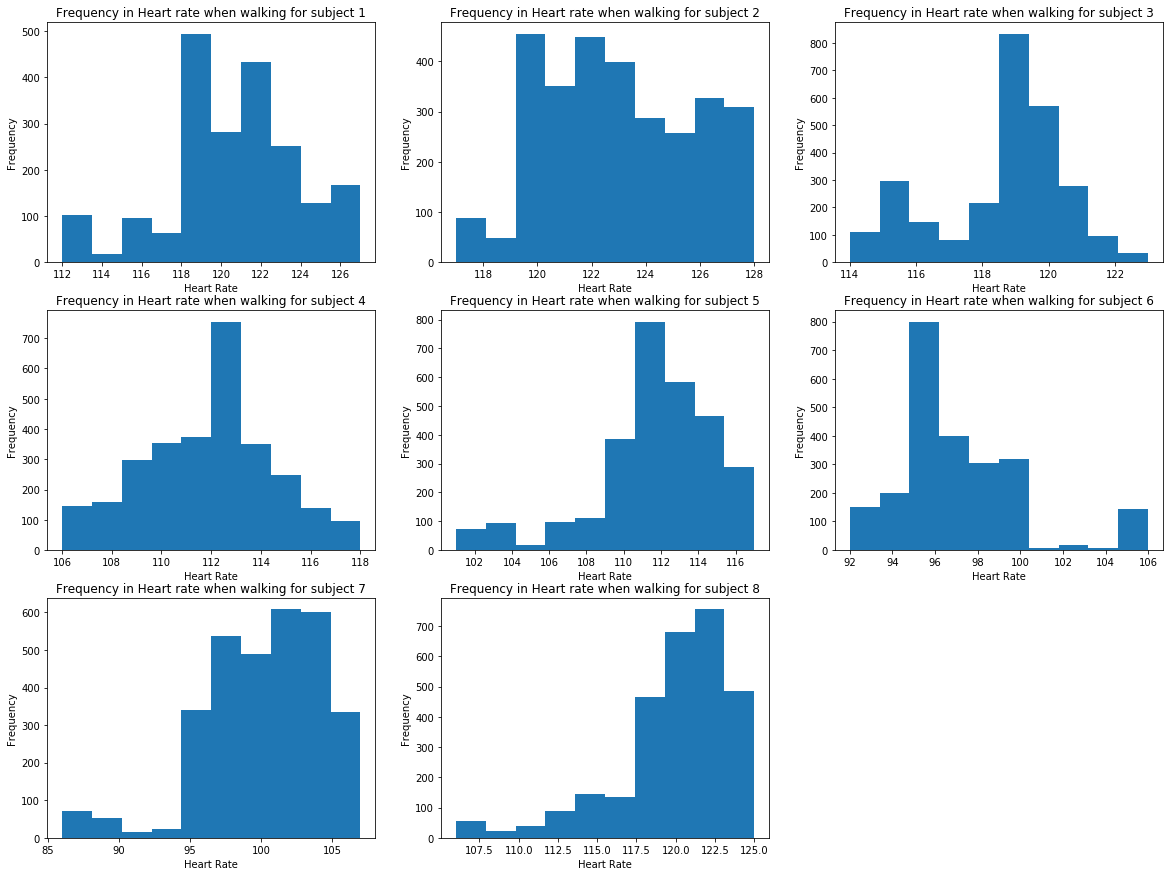

In [13]:
fig = plt.figure(figsize=(20,15))
for i in range(1,9):
    exec(f'ax{i} = fig.add_subplot(3, 3, {i})')
    eval('ax'+str(i)).hist(eval('sub'+str(i)+'_activity4_hr'), bins=10)
    eval('ax'+str(i)).set_title('Frequency in Heart rate when walking for subject '+str(i))
    eval('ax'+str(i)).set_ylabel('Frequency')
    eval('ax'+str(i)).set_xlabel('Heart Rate')

Looking at the graphs above, it doesn't appear that any of the graphs follow the normal distribution. To find out for certain I will still check with the shapiro-wilk tests below.

The Shapiro–Wilk test is a hypothesis test where the null hypothesis is that the sample came from a normally distributed population, and the null hypothesis is that the sample deviates from the normal distribution. The results from this test will be a p-value, and a test statistic w. 

For this test, I will use the standard significance level of $\alpha=0.05$, which means that if the p-value we get is over $\alpha$ then we reject the alternative hypothesis and accept the null hypothesis (the distribution doesn't deviate from normality), and if the p-value is under $\alpha$ then we accept the alternative hypothesis (the distribution does deviate from normality).

In [14]:
# Shapiro wilk test for heart rate when walking 

for i in range(1,9):
    clean_data = eval('sub'+str(i)+'_activity4_hr').dropna()
    shapiro_wilk = stats.shapiro(clean_data)
    print(['Results of test for subject '+ str(i) +' walking: w and p', shapiro_wilk])

['Results of test for subject 1 walking: w and p', (0.963202953338623, 2.42180777530281e-22)]
['Results of test for subject 2 walking: w and p', (0.963025689125061, 6.4373341722668384e-27)]
['Results of test for subject 3 walking: w and p', (0.90372234582901, 5.190404467184651e-38)]
['Results of test for subject 4 walking: w and p', (0.9775328040122986, 4.501417131008059e-21)]
['Results of test for subject 5 walking: w and p', (0.9006144404411316, 6.35145535447545e-40)]
['Results of test for subject 6 walking: w and p', (0.8705103993415833, 2.063117716040785e-40)]
['Results of test for subject 7 walking: w and p', (0.928353488445282, 4.882031296746691e-36)]
['Results of test for subject 8 walking: w and p', (0.8705224394798279, 9.949219096706201e-44)]


As all of the p-values above are under our $\alpha=0.05$, we can conclude that non of the heart rates for walking are normally distributed, to a 5% significance level.

Now I will do the same for running to see if there is any normally distributed distributions. 

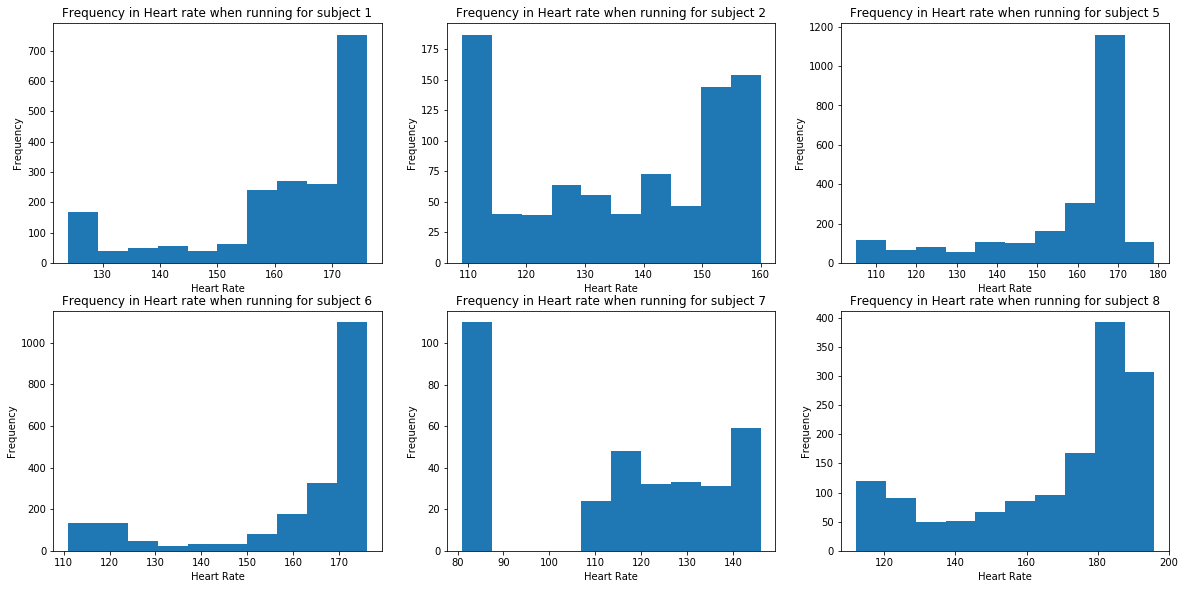

In [15]:
fig = plt.figure(figsize=(20,15))
running_subjects = [1,2,5,6,7,8]
for count, i in enumerate(running_subjects):
    exec(f'ax{count+1} = fig.add_subplot(3, 3, {count+1})')
    eval('ax'+str(count+1)).hist(eval('sub'+str(i)+'_activity5_hr'), bins=10)
    eval('ax'+str(count+1)).set_title('Frequency in Heart rate when running for subject '+str(i))
    eval('ax'+str(count+1)).set_ylabel('Frequency')
    eval('ax'+str(count+1)).set_xlabel('Heart Rate')

Once again, none of the distributions appear to follow a normal distribution. We will again use the Shapiro-Wilk test to show this.

In [16]:
# Shapiro-wilk test

for i in running_subjects:
    clean_data = eval('sub'+str(i)+'_activity5_hr').dropna()
    shapiro_wilk = stats.shapiro(clean_data)
    print(['Results of test for subject '+str(i)+' running: w and p', shapiro_wilk], '\n')

['Results of test for subject 1 running: w and p', (0.7913857698440552, 1.961817850054744e-44)] 

['Results of test for subject 2 running: w and p', (0.8927716016769409, 9.029310598629659e-24)] 

['Results of test for subject 5 running: w and p', (0.7614722847938538, 0.0)] 

['Results of test for subject 6 running: w and p', (0.7176023721694946, 0.0)] 

['Results of test for subject 7 running: w and p', (0.858546257019043, 6.014428910384084e-17)] 

['Results of test for subject 8 running: w and p', (0.8596542477607727, 7.580870515983437e-34)] 



All the p-values are again under $\alpha=0.05$, which shows every distribution deviates from normality to a 5% significance level. 

Now that I have showed that all the distributions deviate from normality, and we know that the activities are independent from each other, I can now use the Mann-Whitney test to see if the difference between heart rate for walking and running is significant enough to use heart rate as an indicator of activity. 

For this test, my null hypothesis will be 'the average heart rates are equal for both walking and running', and my alternative hypothesis will be 'the average heart rate for running is significantly higher than for walking'. Again, I will use a significance level of 5% ($p < 0.05$). I will complete this test for 6 subjects (as there is only 6 subjects that took part in both running and walking in this data set). 

In [17]:
for i in running_subjects:
    walking_hr_vs_running_hr_ttest = stats.mannwhitneyu(eval('sub'+str(i)+'_activity4_hr').dropna(),eval('sub'+str(i)+'_activity5_hr').dropna(),alternative='less')
    print(['The Mann-Whitney result of walking vs running (less than) for subject '+str(i)+':', walking_hr_vs_running_hr_ttest], '\n')

['The Mann-Whitney result of walking vs running (less than) for subject 1:', MannwhitneyuResult(statistic=21360.0, pvalue=0.0)] 

['The Mann-Whitney result of walking vs running (less than) for subject 2:', MannwhitneyuResult(statistic=759986.5, pvalue=3.491827702184976e-69)] 

['The Mann-Whitney result of walking vs running (less than) for subject 5:', MannwhitneyuResult(statistic=315556.5, pvalue=0.0)] 

['The Mann-Whitney result of walking vs running (less than) for subject 6:', MannwhitneyuResult(statistic=0.0, pvalue=0.0)] 

['The Mann-Whitney result of walking vs running (less than) for subject 7:', MannwhitneyuResult(statistic=337934.0, pvalue=3.7893410324462384e-26)] 

['The Mann-Whitney result of walking vs running (less than) for subject 8:', MannwhitneyuResult(statistic=350894.5, pvalue=0.0)] 



As all the p-values we have found are very small (all aprroximately equal to 0), we can conclude from this test that average heart rate when running is significantly higher than when walking. This means that a device can confidently identify if a person is running or walking purely based on the heart rate. 

In addition to this, I would like to see if the same can be said about sitting and walking. If sitting heart rate is significantly lower than walking, then we could confidently say that we can tell the differnce between the 3 activities based on heart rate. 

I will start by again seeing if the heart rates for sitting are normally distributed, firstly by viewing the distributions on histograms. 

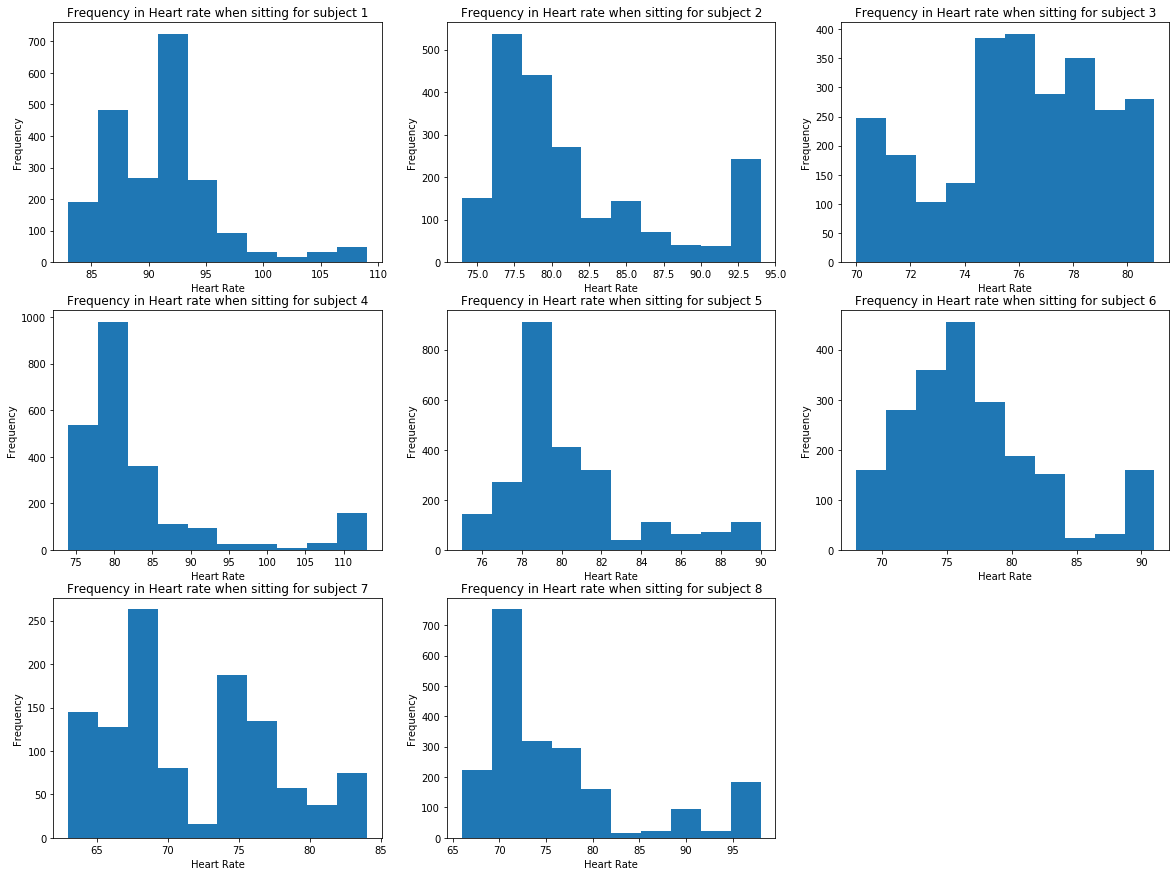

In [18]:
fig = plt.figure(figsize=(20,15))
for i in range(1,9):
    exec(f'ax{i} = fig.add_subplot(3, 3, {i})')
    eval('ax'+str(i)).hist(eval('sub'+str(i)+'_activity2_hr'), bins=10)
    eval('ax'+str(i)).set_title('Frequency in Heart rate when sitting for subject '+str(i))
    eval('ax'+str(i)).set_ylabel('Frequency')
    eval('ax'+str(i)).set_xlabel('Heart Rate')

Again these do not look normally distributed, so we will confirm this with another set of Shapiro-Wilk tests. 

In [19]:
# Shapiro wilk test

for i in running_subjects:
    clean_data = eval('sub'+str(i)+'_activity2_hr').dropna()
    shapiro_wilk = stats.shapiro(clean_data)
    print(['Results of test for subject '+str(i)+' sitting: w and p', shapiro_wilk])

['Results of test for subject 1 sitting: w and p', (0.9070345163345337, 2.635022115936818e-34)]
['Results of test for subject 2 sitting: w and p', (0.8465039730072021, 1.2113524574855881e-40)]
['Results of test for subject 5 sitting: w and p', (0.8487305641174316, 1.7516230804060213e-43)]
['Results of test for subject 6 sitting: w and p', (0.9258356094360352, 4.6988101513102945e-31)]
['Results of test for subject 7 sitting: w and p', (0.938649594783783, 4.043523790449158e-21)]
['Results of test for subject 8 sitting: w and p', (0.7995039224624634, 4.203895392974451e-45)]


As all the p-values above are again lower than $\alpha=0.05$, we can conclude that they deviate from normality. 

Now I will compute the p-values from another Mann-Whitney U test. For this test, my null hypothesis will be 'the average heart rates are equal for both walking and sitting', and my alternative hypothesis will be 'the average heart rate for walking is significantly higher than for sitting'. Again, I will use a significance level of 5% ($p < 0.05$). I will complete this test for 8 subjects (as 8 subjects that took part in both sitting and walking in this data set). 

In [20]:
for i in range(1,9):
    walking_hr_vs_sitting_hr_ttest = stats.mannwhitneyu(eval('sub'+str(i)+'_activity2_hr').dropna(),eval('sub'+str(i)+'_activity4_hr').dropna(),alternative='less')
    print('The Mann-Whitney result of sitting vs walking (less than) for subject '+str(i)+':', walking_hr_vs_sitting_hr_ttest, '\n')

The Mann-Whitney result of sitting vs walking (less than) for subject 1: MannwhitneyuResult(statistic=0.0, pvalue=0.0) 

The Mann-Whitney result of sitting vs walking (less than) for subject 2: MannwhitneyuResult(statistic=0.0, pvalue=0.0) 

The Mann-Whitney result of sitting vs walking (less than) for subject 3: MannwhitneyuResult(statistic=0.0, pvalue=0.0) 

The Mann-Whitney result of sitting vs walking (less than) for subject 4: MannwhitneyuResult(statistic=222860.0, pvalue=0.0) 

The Mann-Whitney result of sitting vs walking (less than) for subject 5: MannwhitneyuResult(statistic=0.0, pvalue=0.0) 

The Mann-Whitney result of sitting vs walking (less than) for subject 6: MannwhitneyuResult(statistic=0.0, pvalue=0.0) 

The Mann-Whitney result of sitting vs walking (less than) for subject 7: MannwhitneyuResult(statistic=0.0, pvalue=0.0) 

The Mann-Whitney result of sitting vs walking (less than) for subject 8: MannwhitneyuResult(statistic=0.0, pvalue=0.0) 



As every p-value is below $\alpha$ we can conclude that walking does have a higher mean heart rate, to a 5% significance level.

Without any need for a hypothesis test, we know that some activities will have very similar ranges in heart rate to these activities (e.g. we found in the data that running and jumping rope have a very similar range in heart rates), so heart rate alone can not be used as an indicator of the exact exersize they are doing. However, the significant differences I found do show that we can accurately distinguish between different levels of activity. 

Sitting is not exercising so the heart rate will be at its lowest (resting), walking is low level exercising (low level), and running is full excersize (high level). Therefore it is possible to determine the amount (or level) of exercise a person is doing using their heart rate, and how long for. 

If we wish to see more precisely when they change excersise, or what activity the subject is doing, we may be able to use clustering to do this. 

##### K-means clustering. 

K- means clustering is a way of grouping data points together into k clusters by taking k means of the data as the centres of the clusters, and then grouping each point to one of those means until every point is asigned to a specific cluster. The algorithm will cluster a data point to the nearest mean point, then it will calculate the new centre of the cluster, and then repeat this process until every data point has been assigned to a cluster. 

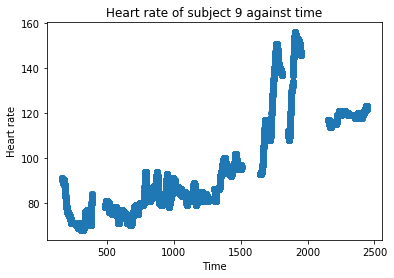

In [21]:
plt.scatter(sub3.timestamp, sub3.heart_rate)
plt.title("Heart rate of subject 9 against time")
plt.xlabel("Time")
plt.ylabel("Heart rate")
plt.show()

In [22]:
# make a function to use k-means clustering to predict a subjects activity using time and heart rate

def k_means_clustering(df, k):
    clf = cluster.KMeans(init = "random", n_clusters = k)
    clf.fit(df[["timestamp", "heart_rate"]])
    df["cluster"] = clf.predict(df[["timestamp", "heart_rate"]])
    for k in range(k):
        clustered_df = df[df['cluster'] == k]
        activity = int(df.loc[df['cluster'] == k, 'activityid'].iloc[0])
        plt.scatter(clustered_df['timestamp'], clustered_df['heart_rate'], label = 'Activity ID = '+str(activity))
    plt.legend()
    plt.title("Heart rate of subject 9 against time")
    plt.xlabel("Time")
    plt.ylabel("Heart rate ")
    plt.show()

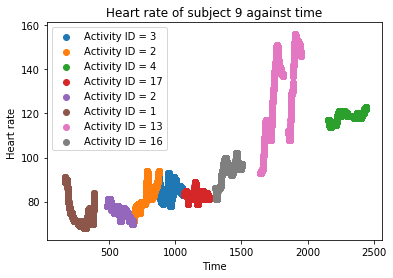

In [23]:
# Test the function on subject 3

clust_sub3 = sub3.dropna()
k_means_clustering(clust_sub3, 8)

In [24]:
# print the start and finsih times for all activities so we can compare them to the clusters times.

def activity_times(df):
    unique_activities = [] 
    for x in df.activityid: 
        if x not in unique_activities: 
            unique_activities.append(x)
    activities_times = {}
    for a_id in unique_activities:
        start = df[df.activityid == a_id].timestamp.iloc[0]
        finish = df[df.activityid == a_id].timestamp.iloc[-1]
        activities_times[a_id]=(start, finish)
    for key, value in activities_times.items():
        print ('Activity ', key, ' start and finish time: ', value)
    return activities_times

sub9_act_times = activity_times(clust_sub3)

Activity  1.0  start and finish time:  (166.17, 386.45)
Activity  2.0  start and finish time:  (481.7, 769.14)
Activity  3.0  start and finish time:  (769.24, 974.54)
Activity  17.0  start and finish time:  (974.65, 1254.21)
Activity  16.0  start and finish time:  (1303.1, 1506.21)
Activity  13.0  start and finish time:  (1641.13, 1949.57)
Activity  12.0  start and finish time:  (1709.6, 1903.2)
Activity  4.0  start and finish time:  (2152.9, 2443.18)


In [25]:
# Now to find the times where the clusters start and finish 

def cluster_times(df):
    unique_clusters = [] 
    for x in df.cluster: 
        if x not in unique_clusters: 
            unique_clusters.append(x)
    cluster_times = {}
    for clust in unique_clusters:
        start = df[df.cluster == clust].timestamp.iloc[0]
        finish = df[df.cluster == clust].timestamp.iloc[-1]
        cluster_times[clust]=(start, finish)
    for key, value in cluster_times.items():
        print ('Cluster', key, 'start and finish time: ', value)
    return cluster_times

sub9_clust_times = cluster_times(clust_sub3)

Cluster 5 start and finish time:  (166.17, 386.45)
Cluster 4 start and finish time:  (481.7, 680.54)
Cluster 1 start and finish time:  (680.65, 875.56)
Cluster 0 start and finish time:  (875.67, 1066.64)
Cluster 3 start and finish time:  (1066.74, 1254.21)
Cluster 7 start and finish time:  (1303.1, 1506.21)
Cluster 6 start and finish time:  (1641.13, 1949.57)
Cluster 2 start and finish time:  (2152.9, 2443.18)


In [26]:
# - find rand and silhouette scores for clusters
# - try agglomerative as well 
# - plot heart rate against IMU data to look for relationships using regression 

## Accelerometer data 

In [27]:
# Calculating velocity of each body part for each activity

# subject 1, activity 1, hand
sub1_activity1 = sub1[sub1.activityid==1]
s1_a1_velocity_hand_x = np.sum(sub1_activity1.hand16_1)*0.01
s1_a1_velocity_hand_y = np.sum(sub1_activity1.hand16_2)*0.01
s1_a1_velocity_hand_z = np.sum(sub1_activity1.hand16_3)*0.01

s1_a1_velocity_hand_total = np.sqrt((s1_a1_velocity_hand_x**2)+(s1_a1_velocity_hand_y**2)+(s1_a1_velocity_hand_z**2))

s1_a1_velocity_hand_total

1740.4508650590733

In [28]:
# Calculating velocity of each body part for each activity

# subject 1, activity 2, hand
sub1_activity2 = sub1[sub1.activityid==2]
s1_a2_velocity_hand_x = np.sum(sub1_activity2.hand16_1)*0.01
s1_a2_velocity_hand_y = np.sum(sub1_activity2.hand16_2)*0.01
s1_a2_velocity_hand_z = np.sum(sub1_activity2.hand16_3)*0.01

s1_a2_velocity_hand_total = np.sqrt((s1_a2_velocity_hand_x**2)+(s1_a2_velocity_hand_y**2)+(s1_a2_velocity_hand_z**2))

s1_a2_velocity_hand_total

2000.4878006694366

In [29]:
# subject 1, activity 3, hand
sub1_activity3 = sub1[sub1.activityid==3]
s1_a3_velocity_hand_x = np.sum(sub1_activity3.hand16_1)*0.01
s1_a3_velocity_hand_y = np.sum(sub1_activity3.hand16_2)*0.01
s1_a3_velocity_hand_z = np.sum(sub1_activity3.hand16_3)*0.01

s1_a3_velocity_hand_total = np.sqrt((s1_a3_velocity_hand_x**2)+(s1_a3_velocity_hand_y**2)+(s1_a3_velocity_hand_z**2))

s1_a3_velocity_hand_total

1692.1073476537108

In [30]:
# subject 1, activity 5, hand
sub1_activity5 = sub1[sub1.activityid==5]
s1_a5_velocity_hand_x = np.sum(sub1_activity5.hand16_1)*0.01
s1_a5_velocity_hand_y = np.sum(sub1_activity5.hand16_2)*0.01
s1_a5_velocity_hand_z = np.sum(sub1_activity5.hand16_3)*0.01

s1_a5_velocity_hand_total = np.sqrt((s1_a5_velocity_hand_x**2)+(s1_a5_velocity_hand_y**2)+(s1_a5_velocity_hand_z**2))

s1_a5_velocity_hand_total  

2689.0735293708553

In [31]:
# subject 1, activity 7, hand
sub1_activity7 = sub1[sub1.activityid==7]
s1_a7_velocity_hand_x = np.sum(sub1_activity7.hand16_1)*0.01
s1_a7_velocity_hand_y = np.sum(sub1_activity7.hand16_2)*0.01
s1_a7_velocity_hand_z = np.sum(sub1_activity7.hand16_3)*0.01

s1_a7_velocity_hand_total = np.sqrt((s1_a7_velocity_hand_x**2)+(s1_a7_velocity_hand_y**2)+(s1_a7_velocity_hand_z**2))

s1_a7_velocity_hand_total

1887.276171781501

In [32]:
# - complete similar analysis on acceleration as i did on heart rate
# - plot heart rate against IMU data and use linear regression to look for relationships 

### Word Count

In [33]:
import io
import os
from nbformat import current

total_markdown = 0
total_heading = 0
total_code = 0

for root, dirs, files in os.walk("."):
    for file in files:
        if file.endswith(".ipynb") and not file.endswith("checkpoint.ipynb") :
            #print(os.path.join(root, file))
            with io.open(os.path.join(root, file), 'r', encoding='utf-8') as f:
                nb = current.read(f, 'json')

            word_count_markdown = 0
            word_count_heading = 0
            word_count_code = 0
            for cell in nb.worksheets[0].cells:
                if cell.cell_type == "markdown":
                    word_count_markdown += len(cell['source'].replace('#', '').lstrip().split(' '))
                elif cell.cell_type == "heading":
                    word_count_heading += len(cell['source'].replace('#', '').lstrip().split(' '))
                elif cell.cell_type == "code":
                    word_count_code += len(cell['input'].replace('#', '').lstrip().split(' '))
            total_markdown += word_count_markdown
            total_heading += word_count_heading
            total_code += word_count_code

print("{} Words in notebooks' markdown" .format(total_markdown))
print("{} Words in notebooks' heading" .format(total_heading))
print("{} Words in notebooks' code" .format(total_code))

1994 Words in notebooks' markdown
31 Words in notebooks' heading
4005 Words in notebooks' code
